# Lab 4: Model Evaluation

In [1]:
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline

Properly evaluating your machine learning model is essential to assess it performance. Importantly, we want to model to be **generalizable**, i.e. it performs well on unseen (future) data.

Typically, the data is split into a **train and test set**. The model is then trained on the former, and its performance is evaluated _in the end_ on the latter. It is _very important_ to only evaluate performance of your model on the test set as the very last step. In case the test performance is used to direct model changes, it is no longer independent and **overfitting** will occur.

In case your model has **hyperparameters** that can be tuned, the data is split into a third set, called the **validation set**. The validation set can then be used to assess the performance for different hyperparameter values to keep the test set separate for the final performance evaluation.

We will now use k-fold cross-validation to develop a random forest machine learning model (random forests will be explained in more detail tomorrow).

In [2]:
# Create the data.
np.random.seed(42)
n_samples, n_features = 93, 2487
X = pd.DataFrame(
    np.random.normal(loc=5, scale=2, size=(n_samples, n_features)),
    columns=[f"feature_{i}" for i in range(n_features)],
    index=[f"run_{i}.mzML" for i in range(n_samples)]
)
y = np.random.choice(2, n_samples)

The data corresponds to the simulated abundance of 2487 metabolite features that were measured in a large experiment consisting of 93 mass spectrometry runs. Additionally, each run corresponds to either a healthy (`0`) or diseased (`1`) patient.

Let's have a look:

In [3]:
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_2477,feature_2478,feature_2479,feature_2480,feature_2481,feature_2482,feature_2483,feature_2484,feature_2485,feature_2486
run_0.mzML,5.993428,4.723471,6.295377,8.046060,4.531693,4.531726,8.158426,6.534869,4.061051,6.085120,...,7.906521,2.322788,6.385837,3.788278,8.438756,8.985031,3.466687,3.900886,6.719176,4.225739
run_1.mzML,4.909178,5.050777,1.160654,4.972325,3.620544,4.013754,7.887264,2.486986,6.626410,4.442074,...,3.688625,4.528578,3.121074,7.238490,4.411088,7.905511,8.057496,4.837908,2.983103,0.828204
run_2.mzML,2.055926,2.252330,7.756939,5.231649,5.779209,0.559158,2.604067,6.774160,5.573548,4.705589,...,5.950670,2.873291,7.043250,2.888020,2.899890,3.180620,6.519000,3.766449,2.304008,3.788640
run_3.mzML,4.935915,2.638055,2.696638,9.222593,3.278869,4.353915,4.265526,4.157286,6.242693,6.896286,...,2.474074,1.177681,3.865105,8.603057,9.044348,8.662354,4.614037,1.435770,0.313922,3.771924
run_4.mzML,4.603853,7.601251,6.735611,5.454810,3.220310,3.078441,5.508255,6.394102,5.783763,2.930804,...,3.784958,3.568066,5.170092,4.521090,4.453736,7.698648,8.076033,1.779957,5.655185,3.446276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_88.mzML,3.806507,3.670578,5.204180,2.399548,2.618634,5.324903,1.828950,4.785490,3.963434,3.388339,...,1.513159,7.196572,3.722868,7.707557,7.287338,4.158642,4.610763,5.666638,3.323116,5.965131
run_89.mzML,7.360723,6.592583,4.191200,2.681019,5.548130,5.687513,3.180419,2.508386,5.554085,6.086354,...,2.686998,3.732852,2.174766,5.167961,5.908628,5.397420,4.165635,5.262110,3.062334,4.336767
run_90.mzML,4.758747,5.039141,0.725145,4.485182,7.003888,1.372274,6.387360,3.858937,2.578285,0.121324,...,5.460655,0.954152,6.702442,2.290225,4.776987,5.672245,7.421326,4.452988,5.129659,2.935674
run_91.mzML,4.830403,4.239582,3.028944,4.927649,3.830394,5.468248,2.831318,7.065347,1.222332,7.378887,...,6.461100,2.179071,7.998166,4.321500,4.799834,3.394000,5.277986,3.861316,7.499670,2.978311


In [4]:
pd.Series(y).map({0: "Healthy", 1: "Diseased"}).value_counts()

Diseased    53
Healthy     40
Name: count, dtype: int64

Great. We hope to create a diagnostic test that can predict disease state from our metabolite read-outs.

Let's try to build a machine learning classifier that predicts whether a run corresponds to healthy or diseased.

This is a typical molecular dataset in which there are much more features $k$ (i.e. measured metabolites) than samples $n$ (i.e. runs/patients). Most machine learning models can't directly deal with data in which $k >> n$.
<br><br>
<details>
<summary><b>What is an approach that we have discussed today that can be used to reduce the number of features?</b> (Click to expand)
</summary>

PCA can be used for dimensionality reduction prior to training the machine learning model.
</details>

We will use **feature selection** to reduce the number of features to be used by the machine learning model. There exist various feature selection methods. Here we will use a statistical test (ANOVA) to determine whether features are associated with our target variable (disease status) and only use statistically significant features (p-value < 0.05) to build our classifier.

In [5]:
# Some utility functions.
class FeatureSelector:
    
    def __init__(self, pval_threshold):
        self.pval_threshold = pval_threshold
    
    def fit(self, X, y):
        _, pval = f_classif(X, y)
        self.X_mask = np.where(pval < self.pval_threshold)[0]
        return self
        
    def transform(self, X):
        return X[:, self.X_mask]
    
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    

def plot_roc(tprs, aucs):
    fig, ax = plt.subplots(figsize=(6, 6))

    mean_tpr, std_tpr = np.nanmean(tprs, axis=0), np.nanstd(tprs, axis=0)
    mean_tpr[0], mean_tpr[-1] = 0, 1
    ax.plot(
        mean_fpr,
        mean_tpr,
        label=f"AUC = {np.mean(aucs):.3f} ± {np.std(aucs):.3f}",
    )
    ax.fill_between(
        mean_fpr,
        mean_tpr - std_tpr,
        mean_tpr + std_tpr,
        alpha=0.2,
    )

    ax.plot([0, 1], [0, 1], c="black", ls="--")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    ax.legend(loc="lower right", frameon=False)

    sns.despine(ax=ax)

    plt.show()
    plt.close()

In [6]:
# Let's build our classifier!
classifier = RandomForestClassifier()

# Only retain features that are statistically significant:
pvalue_threshold = 0.05
X_filtered = FeatureSelector(pvalue_threshold).fit_transform(X.values, y)

# We evaluate the model using 5-fold cross-validation and record the
# performance on the validation set:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 101)
for train, test in StratifiedKFold(n_splits=5).split(X_filtered, y):
    classifier.fit(X_filtered[train], y[train])
    y_pred = classifier.predict(X_filtered[test])
    
    fpr, tpr, _ = roc_curve(y[test], y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc_score(y[test], y_pred))

How did we do? We assess the model performance using an ROC curve.

We show the average ROC curve over all 5 cross-validation folds. The shaded area indicates the standard deviation to assess the robustness of the model.

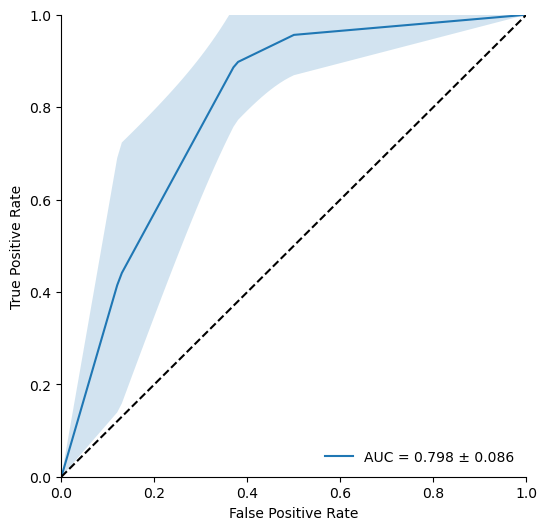

In [7]:
plot_roc(tprs, aucs)

**What do we conclude from the ROC curve?** Are we able to predict disease state from our metabolic markers?
<br><br>
<details>
<summary>(Click to expand)
</summary>

But wait! Scroll up to the second code cell. Our simulated data was _randomly generated_, so there should not be any signal in the data that allows us the predict disease state!
<br><br>
<details>
<summary><b>What did we do wrong?</b> (Click to expand)
</summary>

The problem is that we <i>performed feature selection outside of the cross-validation loop</i>.
    
Remember the **prime directive of machine learning**:

> Only evaluate your models on data that has never been used for training.

Performing feature selection on the _full dataset_ violates this rule, even though we subsequently use cross-validation to train and evaluate our model. This leads to **data leakage**, which is a subtle but common issue. In this case, because we used only statistically significant features for model training, class information _leaked_ to our validation set.
    
Instead, **feature selection needs to be part of the cross-validation set-up**. Let's try this again.
</details>
</details>

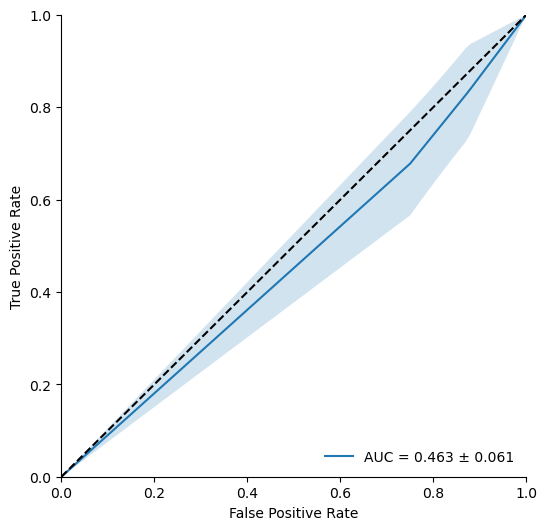

In [8]:
# Now feature selection is part of the model pipeline and will be performed
# for each fold separately during cross-validation:
classifier = make_pipeline(
    FeatureSelector(pvalue_threshold),
    RandomForestClassifier(),
)

# We perform 5-fold cross-validation again:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 101)
for train, test in StratifiedKFold(n_splits=5).split(X, y):
    classifier.fit(X.values[train], y[train])
    y_pred = classifier.predict(X.values[test])
    
    fpr, tpr, _ = roc_curve(y[test], y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc_score(y[test], y_pred))
    
plot_roc(tprs, aucs)

Note the huge difference in classifier performance! Now our model achieved virtually random performance. This is expected, as the input data was randomly generated, and thus no predictive performance is expected.

**Be extremely careful for data leakage!** This can cause a significant optimistic bias during evaluation of your model performance, and such models might perform worse for unseen data. (Or worst case scenario, might not be better than a random coin flip, as in our example.)

Let's try the same for non-random data to further investigate the effects of data leakage.

In [9]:
# Generate a two-class dataset with the same number of features and samples,
# but with only 20 informative features (other features are random):
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_redundant=0,
    n_informative=20,
    random_state=1,
    n_clusters_per_class=1,
)

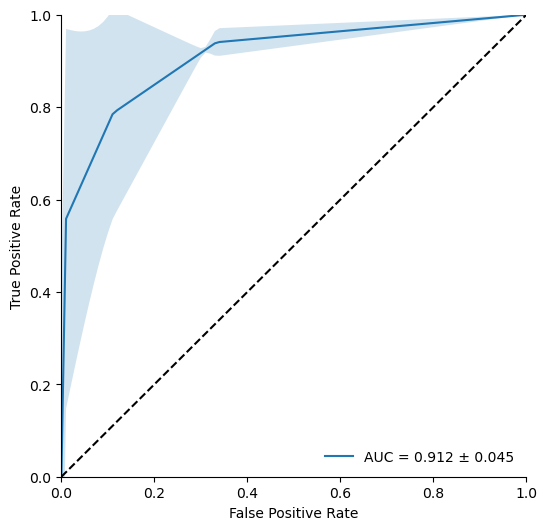

In [10]:
# First we will train our model incorrectly (including data leakage):
# Let's build our classifier!
classifier = RandomForestClassifier()

# Only retain features that are statistically significant:
pvalue_threshold = 0.05
X_filtered = FeatureSelector(pvalue_threshold).fit_transform(X, y)

# We evaluate the model using 5-fold cross-validation and record the
# performance on the validation set:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 101)
for train, test in StratifiedKFold(n_splits=5).split(X_filtered, y):
    classifier.fit(X_filtered[train], y[train])
    y_pred = classifier.predict(X_filtered[test])
    
    fpr, tpr, _ = roc_curve(y[test], y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc_score(y[test], y_pred))
    
plot_roc(tprs, aucs)

We get excellent performance again! Let's see what happens when we perform feature selection _inside_ of the cross-validation loop.

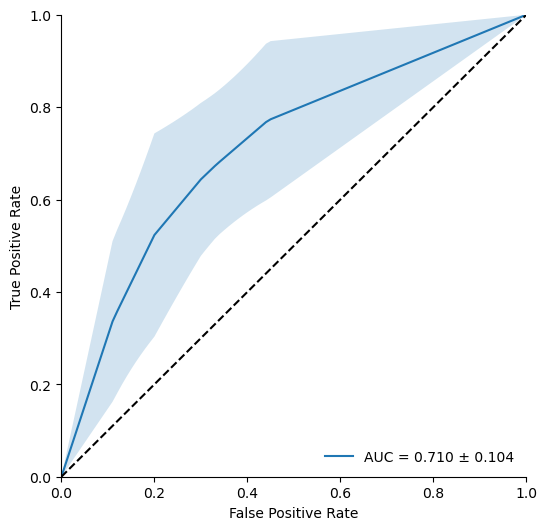

In [11]:
# Now feature selection is part of the model pipeline and will be performed
# for each fold separately during cross-validation:
classifier = make_pipeline(
    FeatureSelector(pvalue_threshold),
    RandomForestClassifier(),
)

# We perform 5-fold cross-validation again:
tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 101)
for train, test in StratifiedKFold(n_splits=5).split(X, y):
    classifier.fit(X[train], y[train])
    y_pred = classifier.predict(X[test])
    
    fpr, tpr, _ = roc_curve(y[test], y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc_score(y[test], y_pred))
    
plot_roc(tprs, aucs)

Play around with the number of informative features for our dataset. How does model performance change when more/fewer features are informative? Why is this the case?

Performance of the correct classifier, without information leakage, is now significantly lower. We have better than random performance, in contrast to the previous example, because there is a true signal in the data. Nevertheless, when information leakage occurs, we might think that our classifier is significantly better than it will actually perform on novel data.

**The prime directive of machine learning:**

> Only evaluate your models on data that has never been used for training.